MSDS 422 Assignment # 4 for James Benco

Assignment 4 Part 2

1: Importing Data amd Required Libraries

In [164]:
from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [165]:
import os
import numpy as np
import pandas as pd
import math, os, re, time, random, string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import category_encoders
from collections import defaultdict
import tensorflow as tf
import re
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU
from keras.layers import Dense, Embedding, Bidirectional, Dropout, Flatten, LSTM
from keras.initializers import Constant
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from keras.optimizers import Adam, SGD
from keras.preprocessing.text import Tokenizer
from keras import Input
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import dummy
from sklearn.metrics import confusion_matrix,classification_report
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [166]:
!pip install wordcloud
import wordcloud

We will first import the data from the Predicting Disaster Dataset

1:Importing Data

In [167]:
#Train Data file
disasterTrainDat = pd.read_csv("train.csv")
TrainDat = disasterTrainDat.copy()

In [168]:
#Test Data File
disasterTestDat = pd.read_csv("test.csv")
TestDat = disasterTestDat.copy()

In [169]:
#Sample Submission File
SubFile = pd.read_csv("sample_submission.csv")

In [170]:
#Checking all the headers and datatypes of the training data
TrainDat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


The data seems to be keywords, locations and texts along with a number target.  This will require language parsing.

2: EDA

In [171]:
#We will see what the data is like and some information about it
TrainDat.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


The data seems to contain three main features:  Keyword, Location and Text, along with our target variable.  The ID column will be used in our final submission of the data and as such will not be affected by the feature engineering.

Text(0.5, 1.0, 'Distribution of Target Variable')

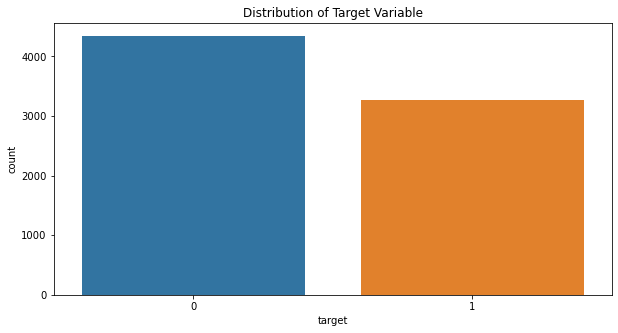

In [172]:
#We shall see our target variable distribution
fig, ax = plt.subplots(figsize = (10,5))
graph1 = sns.countplot(x='target', data = TrainDat)
plt.title('Distribution of Target Variable')
plt.show(graph1)

From this we can see that the majority of the data is not disaster tweets (0), rather than disaster tweets (1).

In [173]:
#We will create a copy of the Training data to work with, so not to affect the actual data
train = TrainDat.copy()
train2 = train.copy()
train2A = train.copy()

We will perform some additional analysis on the data, in the form of creating new features such as word count to help see if there is a pattern we can exploit to aid in our model.

<AxesSubplot:xlabel='word count', ylabel='Density'>

<AxesSubplot:xlabel='word count', ylabel='Density'>

Text(0.5, 1.0, 'Tweet Word Count')

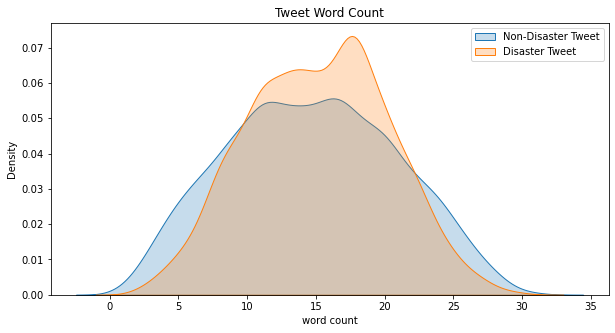

In [174]:
#Creating new feature
train['word count'] = train['text'].apply(lambda x: len(x.split()))

#Defining plot size
fig, ax = plt.subplots(figsize = (10,5))

#Creating the plots
sns.kdeplot(train['word count'][train['target']==0], shade = True, label = 'Non-Disaster Tweet')
sns.kdeplot(train['word count'][train['target']==1], shade = True, label = 'Disaster Tweet')

#Plotting the graphs
plt.title('Tweet Word Count')
plt.legend()
plt.show()

From this there is considerable overlap from the 5-25 wordcount region.   It does seem that the non-disaster tweets tend to be both shorter and longer than the disaster tweets.  With the average disaster tweet word count around 16 words.  Overall, the pattern is that both non-disaster and disaster tweets tend to be normally distributed.

<AxesSubplot:xlabel='character count', ylabel='Density'>

<AxesSubplot:xlabel='character count', ylabel='Density'>

Text(0.5, 1.0, 'Character Count Distribution')

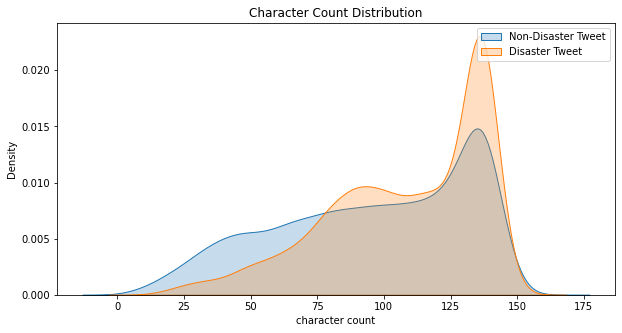

In [175]:
#Testing for character length instead
train['character count'] = train['text'].apply(lambda x: len(x))

fig, ax = plt.subplots(figsize=(10,5))

sns.kdeplot(train['character count'][train['target']==0], shade = True, label = 'Non-Disaster Tweet')
sns.kdeplot(train['character count'][train['target']==1], shade = True, label = 'Disaster Tweet')

plt.title('Character Count Distribution')
plt.legend()
plt.show()

From this we can see that again there is considerable overlap however, most of the disaster tweets are between 75-150 characters while non-disaster tweets are overrepresented in the lower 0-75 character section.  The vast majority of disaster tweets tend to be between 125 and 150 characters long.

2: Cleaning Data

This will be cleaning the data for question 2A and will use words of my choice and my weights.

Below will be defined functions to clean the data removing:
Noise- removing items of little importance such as URLs and HTML tags, this will also include non-important punctuation,.
Stopwords- Words such as 'a', 'an' 'the' which are not important keywords we wish to target
Stem- in this phase we will change all forms of a word to their root to have better accuracy for our model

In [176]:
#removing URLs
def removeURL(sentence):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', sentence)

In [177]:
#removing @ tags
def removeAt(sentence):
    At = re.compile(r'@\S+')
    return At.sub(r'', sentence)

In [178]:
#removing html
def removeHTML(sentence):
    html = re.compile(r'<.*?>')
    return html.sub(r'', sentence)

In [179]:
#removing stopwords
def removeStopwords(sentence):
    return ' '.join([i for i in sentence.split() if i not in wordcloud.STOPWORDS])

In [180]:
#using snowball stemmer to help process words to their roots
stemmer = SnowballStemmer('english')

def stemWords(sentence):
    return ' '.join([stemmer.stem(i) for i in sentence.split()])

In [181]:
#This will be the wrapped function to combine all previosly defined cleaning functions
def cleanData(data):
    data['text'] = data['text'].apply(lambda x: removeURL(x))
    data['text'] = data['text'].apply(lambda x: removeAt(x))
    data['text'] = data['text'].apply(lambda x: removeHTML(x))
    data['text'] = data['text'].apply(lambda x: removeStopwords(x))
    data['text'] = data['text'].apply(lambda x: stemWords(x))
    return data

In [182]:
testData = TestDat.copy()

trainData = cleanData(train)
testData = cleanData(testData)

trainData['text'].head().values

array(['our deed reason #earthquak may allah forgiv us',
       'forest fire near la rong sask. canada',
       'all resid ask shelter place notifi officers. no evacu shelter place order expect',
       '13,000 peopl receiv #wildfir evacu order california',
       'just got sent photo rubi #alaska smoke #wildfir pour school'],
      dtype=object)

3: Tokenizing our cleaned data

In [183]:
train2A = trainData.drop(['id','keyword','location','word count','character count'], axis = 1)
test2A = testData.drop(['id', 'keyword', 'location'], axis =1)

In [184]:
yTrain = train2A['target'].values
xTrain = train2A.drop(['target'], axis=1).values.reshape(len(train2A),)
xTest = test2A['text'].values.reshape(len(test2A),)

In [185]:
#Defining our Tokenizer and applying options
tokenizer = Tokenizer()
tokenizer.fit_on_texts(xTrain)

#Vocabulary Size
vocabSize = len(tokenizer.word_index)+1
print('Size of Vocabulary is: ', vocabSize)


#defining our maximum length which will be 150 from our EDA analysis above
maxlen= 23


Size of Vocabulary is:  13458


In [186]:
xTrainToken = tokenizer.texts_to_sequences(xTrain)
xTestToken = tokenizer.texts_to_sequences(xTest)

print('Text before tokenizing: ', xTrain[0])
print('Text after  tokenizing: ', xTrainToken[0])

Text before tokenizing:  our deed reason #earthquak may allah forgiv us
Text after  tokenizing:  [582, 5790, 512, 259, 105, 1504, 3183, 48]


In [187]:
xTrainPad = pad_sequences(xTrainToken, maxlen = maxlen, padding='post')
xTestPad = pad_sequences(xTestToken, maxlen = maxlen, padding = 'post')

print('Tokenized text before padding: ', xTrainToken[0])
print('Tokenized text before padding: ', xTrainPad[0])

Tokenized text before padding:  [582, 5790, 512, 259, 105, 1504, 3183, 48]
Tokenized text before padding:  [ 582 5790  512  259  105 1504 3183   48    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


4: Building our Model

In [188]:
#We will now define our hidden units and embedding for our model
hiddenUnits = 128
embedUnits = 100


In [189]:
#Building our model and model tuning
model = Sequential()
model.add(Embedding(vocabSize, embedUnits, input_length=maxlen))
model.add(Bidirectional(LSTM(hiddenUnits)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 23, 100)           1345800   
                                                                 
 bidirectional_12 (Bidirecti  (None, 256)              234496    
 onal)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 256)               65792     
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 1)                 257       
                                                     

In [190]:
#defining our learning rate and model summary metrics
learning_rate = 0.0001
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [191]:
#defining batch size and number of iterations
batchSize = 512
numITR1 = 15
numITR2 = 15

#creating two more test models to determine best activation
model2 = Sequential()
model2.add(Embedding(vocabSize, embedUnits, input_length=maxlen))
model2.add(Bidirectional(LSTM(hiddenUnits)))
model2.add(Dropout(0.2))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1,activation='relu'))
learning_rate = 0.0001
model2.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history1 = model.fit(xTrainPad, yTrain, batch_size = batchSize, epochs=numITR1, validation_split=0.2)
history2 = model2.fit(xTrainPad, yTrain, batch_size = batchSize, epochs=numITR2, validation_split=0.2)
model2.summary()

Epoch 1/15
12/12 [==============================] - 8s 378ms/step - loss: 0.6752 - accuracy: 0.5778 - val_loss: 0.6724 - val_accuracy: 0.5351
Epoch 2/15
12/12 [==============================] - 3s 287ms/step - loss: 0.5999 - accuracy: 0.6847 - val_loss: 0.5573 - val_accuracy: 0.7124
Epoch 3/15
12/12 [==============================] - 3s 281ms/step - loss: 0.3866 - accuracy: 0.8475 - val_loss: 0.4761 - val_accuracy: 0.7951
Epoch 4/15
12/12 [==============================] - 3s 280ms/step - loss: 0.2519 - accuracy: 0.9044 - val_loss: 0.4961 - val_accuracy: 0.7820
Epoch 5/15
12/12 [==============================] - 3s 295ms/step - loss: 0.1671 - accuracy: 0.9409 - val_loss: 0.6294 - val_accuracy: 0.7571
Epoch 6/15
12/12 [==============================] - 3s 283ms/step - loss: 0.1197 - accuracy: 0.9585 - val_loss: 0.7421 - val_accuracy: 0.7157
Epoch 7/15
12/12 [==============================] - 3s 277ms/step - loss: 0.0943 - accuracy: 0.9654 - val_loss: 0.8187 - val_accuracy: 0.7347
Epoch 

Text(0.5, 0, 'Epochs')

Text(0.5, 1.0, 'Accuracy over Epochs')

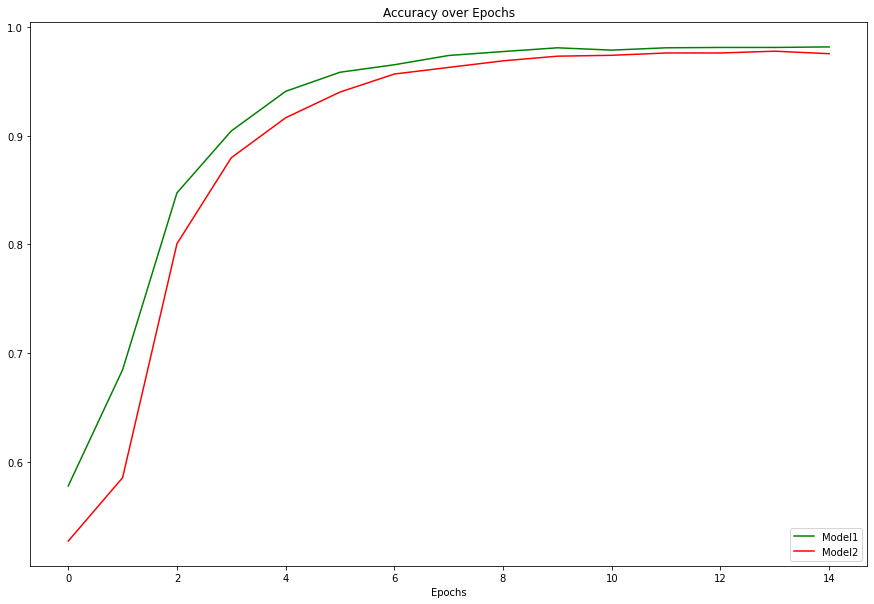

In [192]:
#Charting our model accuracy
fig, ax = plt.subplots(1,sharex = True, sharey=True,figsize=(15,10))
plt.plot(history1.history['accuracy'],color='green',label='Model1')
plt.plot(history2.history['accuracy'],color='red',label='Model2')
plt.xlabel('Epochs')
plt.title('Accuracy over Epochs')
plt.legend(loc='lower right')
plt.show()


Part 2B

This section we will predict using RNN's and GloVe embedding.

In [193]:
#Copying and importing cleaned data for new models and predictions
train2B = trainData.drop(['id','keyword','location','word count','character count'], axis = 1)
test2B = testData.drop(['id', 'keyword', 'location'], axis =1)

In [194]:
y_Train = train2B['target'].values
x_Train = train2B.drop(['target'], axis=1).values.reshape(len(train2B),)
x_Test = test2B['text'].values.reshape(len(test2B),)

5: Tokenizing our cleaned data with GloVe embeddings

In [195]:
#defining our tokenizer
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(x_Train)
sequences = tokenizer2.texts_to_sequences(x_Train)

word_index = tokenizer2.word_index
print('There are %s unique token words.' %len(word_index))

data2B = pad_sequences(sequences, maxlen=23)
labels = y_Train

MAX_SEQUENCE_LENGTH = data2B.shape[1]
MAX_SEQUENCE_LENGTH

There are 13457 unique token words.


23

Importing GloVe embedding

In [196]:
#Importing GloVe embedding
embedding_dict={}
with open('glove.6B.100d.txt', encoding='utf8') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embedding_dict [word] = vector_dimensions


In [197]:
#Loading words into an embedded matrix to be used by our model.
numWords = len(tokenizer2.word_index)+1
embeddingMatrix = np.zeros((numWords,100))

for word, i in tokenizer2.word_index.items():
    if i > numWords:
        continue
    embedVector = embedding_dict.get(word)
    if embedVector is not None:
        embeddingMatrix[i]=embedVector
        
print("Number of words is: ", numWords)
print("Embedding matrix is dimension: ", embeddingMatrix.shape)

Number of words is:  13458
Embedding matrix is dimension:  (13458, 100)


6: Building our model with GloVe embeddings

In [198]:
#Building our embedding for our Sequential RNN model
embedding = tf.keras.layers.Embedding(numWords,100,embeddings_initializer = Constant(embeddingMatrix),
                                     input_length = 28,trainable=True)

In [199]:
#Building our model with embeddings
model3 = Sequential()
model3.add(embedding)
model3.add(Bidirectional(LSTM(hiddenUnits)))
model3.add(Dropout(0.2))
model3.add(Dense(256,activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1,activation='sigmoid'))
model3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 28, 100)           1345800   
                                                                 
 bidirectional_14 (Bidirecti  (None, 256)              234496    
 onal)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 256)               65792     
                                                                 
 dropout_29 (Dropout)        (None, 256)               0         
                                                                 
 dense_29 (Dense)            (None, 1)                 257       
                                                     

In [200]:
#Compiling our model
learning_rate = 0.0001

model3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [201]:
#Running our model
batchSize = 512
numITR3 = 10

history3 = model.fit(data2B, y_Train, batch_size=batchSize, epochs=numITR3, validation_split=0.2,verbose=1)

Epoch 1/10
12/12 [==============================] - 3s 276ms/step - loss: 0.1361 - accuracy: 0.9575 - val_loss: 0.7049 - val_accuracy: 0.7131
Epoch 2/10
12/12 [==============================] - 3s 277ms/step - loss: 0.0902 - accuracy: 0.9749 - val_loss: 1.4287 - val_accuracy: 0.7255
Epoch 3/10
12/12 [==============================] - 3s 273ms/step - loss: 0.0702 - accuracy: 0.9791 - val_loss: 0.8880 - val_accuracy: 0.7367
Epoch 4/10
12/12 [==============================] - 3s 274ms/step - loss: 0.0565 - accuracy: 0.9828 - val_loss: 1.1699 - val_accuracy: 0.7301
Epoch 5/10
12/12 [==============================] - 3s 271ms/step - loss: 0.0506 - accuracy: 0.9824 - val_loss: 1.1892 - val_accuracy: 0.7163
Epoch 6/10
12/12 [==============================] - 3s 274ms/step - loss: 0.0542 - accuracy: 0.9811 - val_loss: 1.1398 - val_accuracy: 0.7209
Epoch 7/10
12/12 [==============================] - 3s 281ms/step - loss: 0.0473 - accuracy: 0.9829 - val_loss: 1.1017 - val_accuracy: 0.7354
Epoch 

7: Evaluation

Text(0.5, 0, 'Epochs')

Text(0.5, 1.0, 'Accuracy over Epochs')

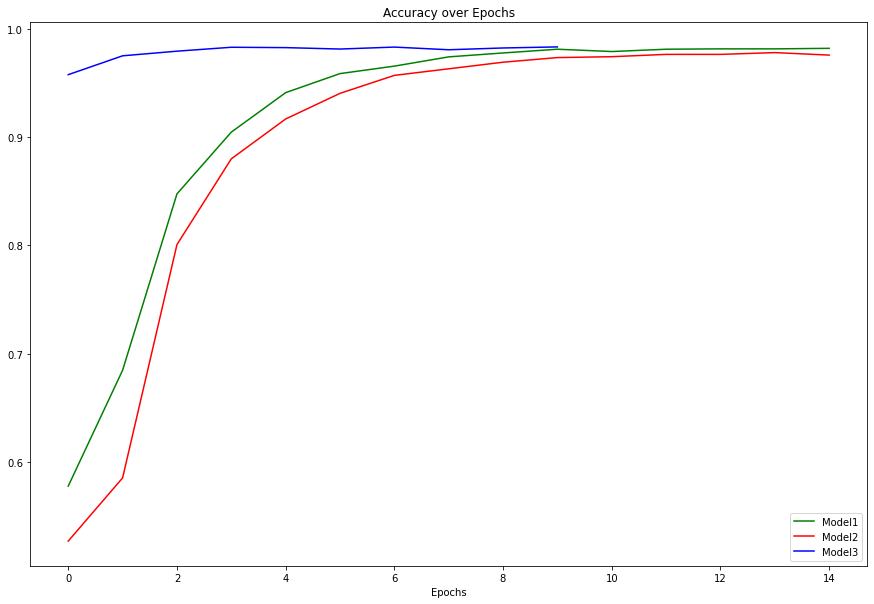

In [202]:
#Charting our model accuracy
fig, ax = plt.subplots(1,sharex = True, sharey=True,figsize=(15,10))
plt.plot(history1.history['accuracy'],color='green',label='Model1')
plt.plot(history2.history['accuracy'],color='red',label='Model2')
plt.plot(history3.history['accuracy'],color='blue',label='Model3')
plt.xlabel('Epochs')
plt.title('Accuracy over Epochs')
plt.legend(loc='lower right')
plt.show()


It seems that the best models were model3 using the GloVe embeddings and out model 1.  Model 3 achieved the highest accuracy score over the shortest epoch duration.

8: Submission

In [203]:
predict = model.predict(xTestPad)

102/102 [==============================] - 2s 13ms/step


In [204]:
submission = pd.read_csv("sample_submission.csv")
submission['target']=predict
submission['target']=submission['target'].apply(lambda x: 0 if x<=.5 else 1)

In [205]:
submission.to_csv('Submission.csv',index=False)